In [1]:
print('\nEnabling interactive shell outputs ...')
print('   Use command pass; to disable cell text outputs')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore') 
warnings.simplefilter(action="ignore",category=UserWarning)
warnings.simplefilter(action="ignore",category=FutureWarning)

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}


Enabling interactive shell outputs ...
   Use command pass; to disable cell text outputs


## Factorial with blocking factor and covariates

### Factorial with blocking

Pooling Sum of squares

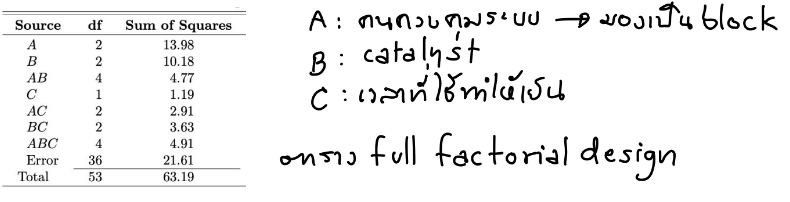

In [2]:
# sum of squares full factorial
SSb = 10.18
SSc = 1.19
SSbc = 3.63
SSblock = 13.98
SSab = 4.77
SSac = 2.91
SSabc = 4.91
SSe = 21.61

# pooling sum of squares
SSE = SSab + SSac + SSabc + SSe

# mean square
MSb = SSb/2
MSc = SSc/1
MSbc = SSbc/2
MSblock = SSblock/2
MSe = SSE/46

# f-test statistics
Fb = MSb/MSe
Fc = MSc/MSe
Fbc = MSbc/MSe

In [3]:
# p-value of factor B
from scipy import stats
Pb = stats.f.sf(Fb, 2, 46)
Pb

0.0024962759217158474

In [4]:
# p-value of factor B
Pc = stats.f.sf(Fc, 1, 46)
Pc

0.2121918223387006

In [5]:
# p-value of interaction AB
Pbc = stats.f.sf(Fbc, 2, 46)
Pbc

0.09825724649712028

### Single factor with covariate

In [6]:
cracker_data = pd.read_excel('data/lect06-ancova.xlsx', sheet_name='Cracker')
cracker_data

,PromotionSold,PreviousSold,Promotion,Store
0,38,21,1,1
1,39,26,1,2
2,36,22,1,3
3,45,28,1,4
4,33,19,1,5
5,43,34,2,1
6,38,26,2,2
7,38,29,2,3
8,27,18,2,4
9,34,25,2,5


1. encode category factor to indicator variable 

a factor with 'a' treatment levels will be convert to a-1 indicator variables

In [7]:
def codingfunc(x):
    if x == 1: # the first treatment level of factor
        return (1,0) # 2 indicator variables
    elif x == 2: # the second treatment level of factor
        return (0,1)
    else: # the third treatment level of factor
        return (-1,-1)

cracker_data[['I1', 'I2']] = pd.DataFrame(cracker_data['Promotion'].apply(codingfunc).tolist(), 
                                           index=cracker_data.index)
cracker_data.PreviousSold -= cracker_data.PreviousSold.mean()
cracker_data

,PromotionSold,PreviousSold,Promotion,Store,I1,I2
0,38,-4.0,1,1,1,0
1,39,1.0,1,2,1,0
2,36,-3.0,1,3,1,0
3,45,3.0,1,4,1,0
4,33,-6.0,1,5,1,0
5,43,9.0,2,1,0,1
6,38,1.0,2,2,0,1
7,38,4.0,2,3,0,1
8,27,-7.0,2,4,0,1
9,34,0.0,2,5,0,1


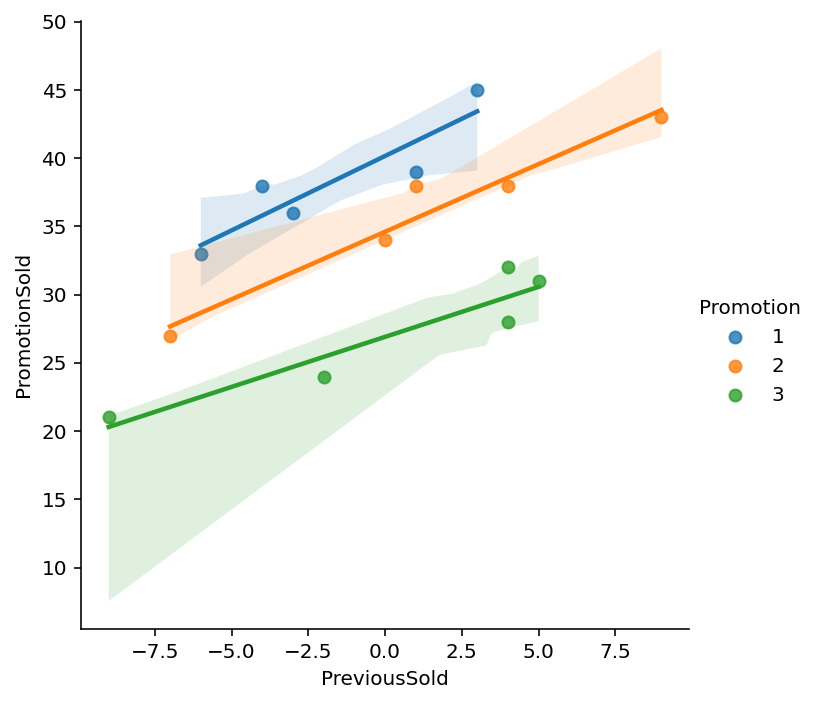

In [8]:
import seaborn as sns
sns.lmplot(data=cracker_data, x="PreviousSold", y="PromotionSold", hue="Promotion")

2. comparing between ANOVA model and ANCOVA model

In [9]:
# ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'PromotionSold ~ C(Promotion)'

cracker_lm = ols(formula, data=cracker_data).fit()
aov_table = anova_lm(cracker_lm) 
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Promotion),2.0,338.8,169.400000,6.608583,0.011612
Residual,12.0,307.6,25.633333,NaN,NaN


In [10]:
# ANCOVA
from statsmodels.formula.api import ols

formula = 'PromotionSold ~ I1 + I2 + PreviousSold'
cracker_lm = ols(formula, data=cracker_data).fit()
cracker_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.924   
Dependent Variable: PromotionSold    AIC:                64.7350 
Date:               2021-12-05 01:29 BIC:                67.5672 
No. Observations:   15               Log-Likelihood:     -28.368 
Df Model:           3                F-statistic:        57.78   
Df Residuals:       11               Prob (F-statistic): 5.08e-07
R-squared:          0.940            Scale:              3.5065  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept     33.8000    0.4835  69.9079  0.0000  32.7358  34.8642
I1             6.0174    0.7083   8.4961  0.0000   4.4585   7.5763
I2             0.9420    0.6987   1.3483  0.2047  -0.5958   2.4798
PreviousSold   0.8986    0.1026   8.7592  0.0000   0.6728   1.1243
-----------------------------------------------------------------
Omnibus:              3.304        Durbin-Watson:           2.497
Prob(Omnibus):        0.192        Jarque-Bera (JB):        1.380
Skew:                 0.337        Prob(JB):                0.502
Kurtosis:             1.675        Condition No.:           9    
=================================================================

"""

In [11]:
print('MSE (ANCOVA): {:.2f}'.format(cracker_lm.mse_resid))

MSE (ANCOVA): 3.51


In [12]:
def check_linreg_residuals(model):

    kws = dict(color='blue', marker='o', markersize=7, alpha=0.5)
    sns1_kws = dict(marker='o', s=70, alpha=0.5)
    sns2_kws = dict(marker='o', s=7, alpha=0.5)
    
    x = model.resid
    yhat = model.fittedvalues
    
    fig = plt.figure(figsize=(9, 7))

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.scatter(yhat, x, **sns1_kws)
    ax1.set_title('Residuals vs. Fitted values')
    
    n=len(x)
    #sns.residplot(np.linspace(1,n,n), x, ax=ax2, scatter_kws=sns1_kws)
    #ax2.set_title('Sequence plot')
    ax2.scatter(yhat+x, yhat, **sns1_kws)
    ax2.set_title('Actual vs. Fitted values')
      
    # Box plot
    ax3.boxplot(x,showmeans=True)
    ax3.set_title('Boxplot')

    # qq plot
    sm.graphics.qqplot(x,line='q', ax=ax4, **kws)
    ax4.set_title('Normal Q-Q plot')
    plt.tight_layout()

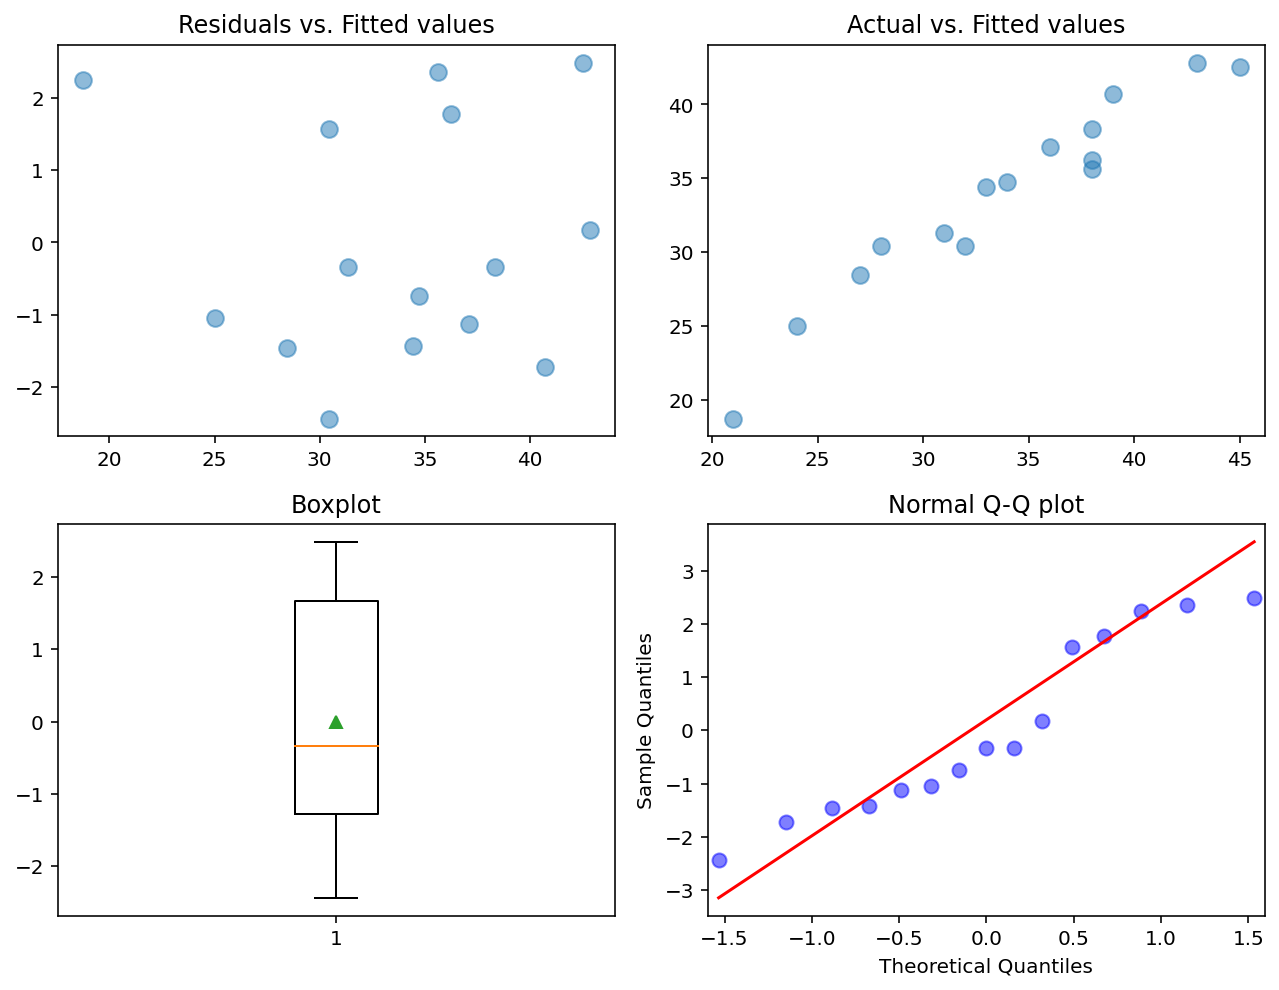

In [13]:
check_linreg_residuals(cracker_lm)

3. Partial F-test for treatment effects

In [14]:
# remove all indicator varaibles indicating the main factor

cracker_reduced_lm = ols('PromotionSold ~ PreviousSold', data=cracker_data).fit()
cracker_reduced_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.241  
Dependent Variable: PromotionSold    AIC:                97.7757
Date:               2021-12-05 01:29 BIC:                99.1918
No. Observations:   15               Log-Likelihood:     -46.888
Df Model:           1                F-statistic:        5.439  
Df Residuals:       13               Prob (F-statistic): 0.0364 
R-squared:          0.295            Scale:              35.056 
----------------------------------------------------------------
                  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------
Intercept        33.8000   1.5287 22.1098 0.0000 30.4974 37.1026
PreviousSold      0.7278   0.3121  2.3322 0.0364  0.0536  1.4019
----------------------------------------------------------------
Omnibus:              2.085        Durbin-Watson:          0.378
Prob(Omnibus):        0.353        Jarque-Bera (JB):       1.024
Skew:                 -0.194       Prob(JB):               0.599
Kurtosis:             1.780        Condition No.:          5    
================================================================

"""

In [15]:
print('SSE_k (reduced model): {:.2f} '.format(cracker_reduced_lm.ssr))
print('SSE (full model): {:.2f} '.format(cracker_lm.ssr))
print('MSE (full model): {:.2f} '.format(cracker_lm.mse_resid))

SSE_k (reduced model): 455.72 
SSE (full model): 38.57 
MSE (full model): 3.51 


In [16]:
# performing Partial F-test using full model and reduced model

from scipy import stats
k=2 # k = number of removed predictor from full model
partial_F0 = ((cracker_reduced_lm.ssr-cracker_lm.ssr)/k)/cracker_lm.mse_resid
print('Test statistic: {:.2f}, P-value: {:.4f}'.format(partial_F0, 
                                                       stats.f.sf(partial_F0, k, cracker_lm.df_resid)))
print('Critical value at 0.05: {:.2f} '.format(stats.f.isf(0.05, k, cracker_lm.df_resid)))

Test statistic: 59.48, P-value: 0.0000
Critical value at 0.05: 3.98 


4. test for parallel slope

In [17]:
cracker_data['I1x'] = cracker_data['I1']*cracker_data['PreviousSold']
cracker_data['I2x'] = cracker_data['I2']*cracker_data['PreviousSold']
cracker_data

,PromotionSold,PreviousSold,Promotion,Store,I1,I2,I1x,I2x
0,38,-4.0,1,1,1,0,-4.0,-0.0
1,39,1.0,1,2,1,0,1.0,0.0
2,36,-3.0,1,3,1,0,-3.0,-0.0
3,45,3.0,1,4,1,0,3.0,0.0
4,33,-6.0,1,5,1,0,-6.0,-0.0
5,43,9.0,2,1,0,1,0.0,9.0
6,38,1.0,2,2,0,1,0.0,1.0
7,38,4.0,2,3,0,1,0.0,4.0
8,27,-7.0,2,4,0,1,-0.0,-7.0
9,34,0.0,2,5,0,1,0.0,0.0


In [18]:
# fit regression
from statsmodels.formula.api import ols

formula = 'PromotionSold ~ I1 + I2 + PreviousSold + I1x + I2x'
cracker_p_lm = ols(formula, data=cracker_data).fit()
cracker_p_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.924   
Dependent Variable: PromotionSold    AIC:                65.7071 
Date:               2021-12-05 01:29 BIC:                69.9554 
No. Observations:   15               Log-Likelihood:     -26.854 
Df Model:           5                F-statistic:        35.11   
Df Residuals:       9                Prob (F-statistic): 1.22e-05
R-squared:          0.951            Scale:              3.5023  
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept     33.8943    0.5123  66.1555  0.0000  32.7353  35.0533
I1             6.2699    0.7517   8.3413  0.0000   4.5695   7.9703
I2             0.7179    0.7160   1.0027  0.3422  -0.9018   2.3376
PreviousSold   0.9387    0.1127   8.3320  0.0000   0.6839   1.1936
I1x            0.1525    0.1844   0.8271  0.4296  -0.2646   0.5696
I2x            0.0525    0.1456   0.3607  0.7267  -0.2769   0.3819
-----------------------------------------------------------------
Omnibus:              1.574        Durbin-Watson:           2.319
Prob(Omnibus):        0.455        Jarque-Bera (JB):        1.039
Skew:                 0.354        Prob(JB):                0.595
Kurtosis:             1.923        Condition No.:           10   
=================================================================

"""

In [19]:
print('SSE_k (reduced model): {:.2f} '.format(cracker_lm.ssr))
print('SSE (full model): {:.2f} '.format(cracker_p_lm.ssr))
print('MSE (full model): {:.2f} '.format(cracker_p_lm.mse_resid))

SSE_k (reduced model): 38.57 
SSE (full model): 31.52 
MSE (full model): 3.50 


In [20]:
# performing Partial F-test using full model and reduced model

from scipy import stats
k=2
partial_F0 = ((cracker_lm.ssr-cracker_p_lm.ssr)/k)/cracker_p_lm.mse_resid
print('Test statistic: {:.2f}, P-value: {:.4f}'.format(partial_F0, 
                                                       stats.f.sf(partial_F0, k, cracker_p_lm.df_resid)))
print('Critical value at 0.05: {:.2f} '.format(stats.f.isf(0.05, k, cracker_p_lm.df_resid)))

Test statistic: 1.01, P-value: 0.4032
Critical value at 0.05: 4.26 


Do not reject H0 = slope is parallel

5. interval estimation

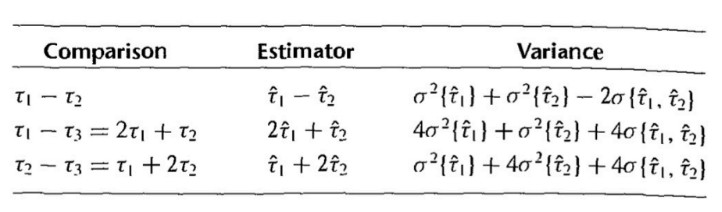

In [21]:
# calculate estimator (mean of sum of random variables)
t1 = 6.0174
t2 = 0.9420
est1 = t1 - t2
est2 = 2*t1 + t2
est3 = t1 + 2*t2
est1, est2, est3

(5.0754, 12.9768, 7.901400000000001)

In [22]:
# calculate variance and covarince

import statsmodels.api as sm
from numpy.linalg import inv

Xreg = sm.add_constant(cracker_data[['I1','I2','PreviousSold']]) 
Covmat = cracker_lm.mse_resid*inv(Xreg.T@Xreg)
np.set_printoptions(precision=4)
Covmat

array([[ 0.2338,  0.    ,  0.    ,  0.    ],
       [-0.    ,  0.5016, -0.2603,  0.0189],
       [ 0.    , -0.2603,  0.4882, -0.0147],
       [ 0.    ,  0.0189, -0.0147,  0.0105]])

In [23]:
var1 = Covmat[1][1] + Covmat[2][2] - 2*Covmat[1][2]
var2 = 4*Covmat[1][1] + Covmat[2][2] + 4*Covmat[1][2]
var3 = Covmat[1][1] + 4*Covmat[2][2] + 4*Covmat[1][2]
var1, var2, var3

(1.510355287373054, 1.453527538266208, 1.4131166944568962)

In [24]:
def interval_est(est, var, g, alpha=0.05):
    crit_val = stats.norm.isf(alpha/(2*g))
    margin_err = np.sqrt(var)*crit_val
    
    return est - margin_err, est + margin_err

In [25]:
g = 3 # number of comparison pairs
interval_est(est1, var1, g)
interval_est(est2, var2, g)
interval_est(est3, var3, g)

(2.1332823073935194, 8.01751769260648)

(10.090562176822974, 15.863037823177027)

(5.055566449427197, 10.747233550572805)

6. adjusted estimated mean response

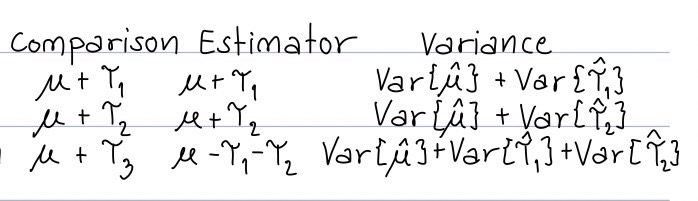

In [26]:
mean = 33.8000
aest1 = mean + t1
aest2 = mean + t2
aest3 = mean - t1 - t2
aest1, aest2, aest3

(39.8174, 34.742, 26.840599999999995)

In [27]:
avar1 = Covmat[0][0] + Covmat[1][1]
avar2 = Covmat[0][0] + Covmat[2][2]
avar3 = Covmat[0][0] + Covmat[1][1] + Covmat[2][2]
avar1, avar2, avar3

(0.7353931680715511, 0.7219228868017804, 1.2235505486708502)

In [28]:
interval_est(aest1, avar1, g)
interval_est(aest2, avar2, g)
interval_est(aest3, avar3, g)

(37.76444099573214, 41.87035900426786)

(32.707930036827506, 36.77606996317249)

(24.192517936897417, 29.488682063102573)

### Two factor with covariate

In [29]:
flower_data = pd.read_excel('data/lect06-ancova.xlsx', sheet_name='Flower')
flower_data

,Sales,Plot,Variety,Moisture,Rep
0,98,15,1,1,1
1,60,4,1,1,2
2,77,7,1,1,3
3,80,9,1,1,4
4,95,14,1,1,5
5,64,5,1,1,6
6,55,4,2,1,1
7,60,5,2,1,2
8,75,8,2,1,3
9,65,7,2,1,4


In [30]:
def codingfunc(x):
    if x == 1:
        return 1
    else:
        return -1
      
flower_data['I1'] = flower_data['Variety'].apply(codingfunc)
flower_data['I2'] = flower_data['Moisture'].apply(codingfunc)
flower_data['I1I2'] = flower_data['I1']*flower_data['I2'] 
flower_data.Plot -= flower_data.Plot.mean()
flower_data

,Sales,Plot,Variety,Moisture,Rep,I1,I2,I1I2
0,98,6.75,1,1,1,1,1,1
1,60,-4.25,1,1,2,1,1,1
2,77,-1.25,1,1,3,1,1,1
3,80,0.75,1,1,4,1,1,1
4,95,5.75,1,1,5,1,1,1
5,64,-3.25,1,1,6,1,1,1
6,55,-4.25,2,1,1,-1,1,-1
7,60,-3.25,2,1,2,-1,1,-1
8,75,-0.25,2,1,3,-1,1,-1
9,65,-1.25,2,1,4,-1,1,-1


In [31]:
from statsmodels.formula.api import ols

formula = 'Sales ~ I1 + I2 + I1I2 + Plot'
flower_lm = ols(formula, data=flower_data).fit()
flower_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.972   
Dependent Variable: Sales            AIC:                116.6316
Date:               2021-12-05 01:29 BIC:                122.5218
No. Observations:   24               Log-Likelihood:     -53.316 
Df Model:           4                F-statistic:        197.4   
Df Residuals:       19               Prob (F-statistic): 3.43e-15
R-squared:          0.977            Scale:              6.2885  
------------------------------------------------------------------
              Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept    70.0000    0.5119  136.7511  0.0000  68.9286  71.0714
I1            2.0423    0.5211    3.9194  0.0009   0.9517   3.1330
I2            3.6808    0.5129    7.1763  0.0000   2.6072   4.7543
I1I2          0.8192    0.5129    1.5972  0.1267  -0.2543   1.8928
Plot          3.2769    0.1300   25.2034  0.0000   3.0048   3.5490
-----------------------------------------------------------------
Omnibus:              4.855        Durbin-Watson:           1.974
Prob(Omnibus):        0.088        Jarque-Bera (JB):        3.784
Skew:                 0.973        Prob(JB):                0.151
Kurtosis:             2.979        Condition No.:           4    
=================================================================

"""

In [32]:
# interaction is not significant

formula = 'Sales ~ I1 + I2 + Plot'
flower_lm = ols(formula, data=flower_data).fit()
flower_lm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.969   
Dependent Variable: Sales            AIC:                117.6552
Date:               2021-12-05 01:29 BIC:                122.3674
No. Observations:   24               Log-Likelihood:     -54.828 
Df Model:           3                F-statistic:        243.5   
Df Residuals:       20               Prob (F-statistic): 6.60e-16
R-squared:          0.973            Scale:              6.7762  
------------------------------------------------------------------
              Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept    70.0000    0.5314  131.7381  0.0000  68.8916  71.1084
I1            2.0522    0.5409    3.7942  0.0011   0.9240   3.1805
I2            3.6841    0.5324    6.9194  0.0000   2.5735   4.7947
Plot          3.2637    0.1347   24.2307  0.0000   2.9828   3.5447
-----------------------------------------------------------------
Omnibus:              2.838        Durbin-Watson:           1.731
Prob(Omnibus):        0.242        Jarque-Bera (JB):        2.435
Skew:                 0.715        Prob(JB):                0.296
Kurtosis:             2.373        Condition No.:           4    
=================================================================

"""

This example has one coefficient for each factor and the coded variables  
are uncorrelated. So the significance of a factor can be determined from 
that of the coefficient.


Significance of factor can be generally determined from partial f-tests.  
The reduced models are obtained by removing coefficients related to each  
factor at the time.

In [33]:
import statsmodels.api as sm
from numpy.linalg import inv

Xreg = sm.add_constant(flower_data[['I1', 'I2', 'I1I2', 'Plot']])
Covmat = flower_lm.mse_resid*inv(Xreg.T@Xreg)
np.set_printoptions(precision=4)
print(Covmat)

[[ 0.2823  0.      0.      0.      0.    ]
 [ 0.      0.2926  0.0034 -0.0034 -0.0137]
 [ 0.      0.0034  0.2835 -0.0011 -0.0046]
 [ 0.     -0.0034 -0.0011  0.2835  0.0046]
 [ 0.     -0.0137 -0.0046  0.0046  0.0182]]


## Random and Mixed effects models

### single factor random

In [34]:
# hypothesis test (F-test)
# F* = MStr/MSE ~F(a-1, a(n-1))

stats.f.sf(29.73/1.90, 3, 12)

0.00018971273962313772

In [35]:
# estimating variance component
# var_t = (MStr-MSE)/n

(29.73-1.90)/4

6.9575000000000005

In [36]:
# total variance
# total_var = var_t + mse(experimental error)

6.96+1.90

8.86

Interval estimation of total mean response

In [37]:
total_mean_y = 1527/16
# ~t(alpha/2, a-1)
crit_val = stats.t.isf(0.05/2,3)
# crit_val*np.sqrt(MStr/an)
margin_err = crit_val*np.sqrt(29.73/16)
total_mean_y - margin_err, total_mean_y + margin_err

(91.09941009653082, 99.77558990346918)

Interval estimation of proportion of variability

In [38]:
#Estimate of the proportion of variability
6.96/8.86

0.7855530474040633

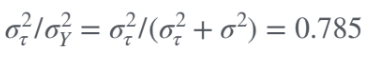

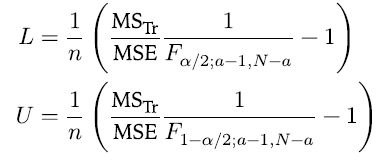

In [39]:
L = (1/4)*(((29.73/1.90)*(1/stats.f.isf(0.05/2, 3, 12))) - 1)
U = (1/4)*(((29.73/1.90)*(1/stats.f.isf(1-0.05/2, 3, 12))) - 1)

In [40]:
(L/(1+L)), (U/(1+U))

(0.38435546145345206, 0.9824043811809573)

Interval estimation of variance component

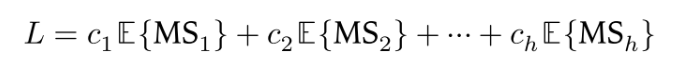

In [41]:
# var_t = (MStr-MSE)/n
# var_t = 1/n*MStr - 1/n*MSE

(29.73-1.90)/4

6.9575000000000005

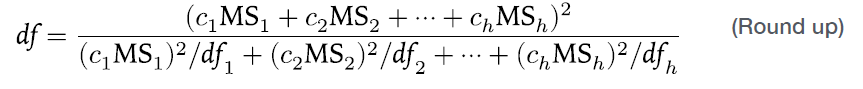

In [42]:
import math

def df(n, ms1, ms2, df1, df2):
    # calculate c1 c2
    c1 = 1/n
    c2 = -1/n
    
    return math.ceil((((c1*ms1 + c2*ms2)**2)/(((c1*ms1)**2/df1) + ((c2*ms2)**2/df2))))

In [43]:
df(n=4 , ms1=29.73, ms2=1.90, df1=3, df2=12)

3

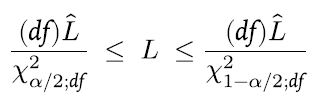

In [44]:
def var_interval_est(L, df, alpha=0.05):
    low_crit_val = stats.chi2.isf(alpha/2, df)
    up_crit_val = stats.chi2.isf(1-alpha/2, df)
    
    lower = (df*L)/low_crit_val
    upper = (df*L)/up_crit_val
    
    # variance and standard deviation
    return lower, upper, np.sqrt(lower), np.sqrt(upper)

In [45]:
var_interval_est(L=6.96, df=3)

(2.233536428610944, 96.7583709250541, 1.4945020671149787, 9.836583295283688)

## Nested design

In [46]:
df = pd.DataFrame({'score':[25, 29, 14, 11, 11, 6, 22, 18, 17, 20, 5, 2],
                   'school':['1','1','1','1','2','2','2','2','3','3','3','3'],
                  'instructor':['1','1','2','2','1','1','2','2','1','1','2','2']})
df

,score,school,instructor
0,25,1,1
1,29,1,1
2,14,1,2
3,11,1,2
4,11,2,1
5,6,2,1
6,22,2,2
7,18,2,2
8,17,3,1
9,20,3,1


In [47]:
formula = 'score ~ school + instructor + school:instructor'

lm = ols(formula, data=df).fit()
aov_table = anova_lm(lm) 
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
school,2.0,156.5,78.25,11.178571,0.009473
instructor,1.0,108.0,108.00,15.428571,0.007731
school:instructor,2.0,459.5,229.75,32.821429,0.000587
Residual,6.0,42.0,7.00,NaN,NaN


Multiple pairwise comparison of fixed effects

In [48]:
from statsmodels.stats.libqsturng import qsturng
import itertools

# find group_mean and factor_list before using the function

# group_mean = df.groupby('factor').aggregate({'response':'mean'}).response
# factor_list = sorted(df.factor.unique())

def multi_pairwise(factor_list, group_mean, a, b, n, mse, alpha=0.05):
    f = a*b*(n-1)
    q_crit = qsturng(1-alpha, a, f)
    margin_err = q_crit*np.sqrt(mse/(b*n))
    
    allpairs=list(itertools.combinations(factor_list, 2))

    ci_df = pd.DataFrame(allpairs, columns={'group1','group2'})
    ci_df['meandiff'] = ci_df.apply(lambda x: group_mean[x['group2']] - group_mean[x['group1']], axis=1) 
    ci_df['lower'] = ci_df.apply(lambda x: x['meandiff'] - margin_err, axis=1) 
    ci_df['upper'] = ci_df.apply(lambda x: x['meandiff'] + margin_err, axis=1) 
    ci_df['reject'] = ci_df.apply(lambda x: 'False' if x['lower'] < 0 and x['upper'] > 0 else 'True', axis=1) 
    
    return ci_df

In [49]:
group_mean = df.groupby('school').aggregate({'score':'mean'}).score
factor_list  = sorted(df.school.unique())

multi_pairwise(factor_list=factor_list, group_mean=group_mean, a=3, b=2, n=2, mse=7, alpha=0.1)

,group1,group2,meandiff,lower,upper,reject
0,1,2,-5.50,-10.201918,-0.798082,True
1,1,3,-8.75,-13.451918,-4.048082,True
2,2,3,-3.25,-7.951918,1.451918,False


## $2^k$ Factorial Design

Contrasts and Effect Estimates

In [50]:
import string
import pandas as pd
from itertools import combinations

# Return 2-level design matrix for k factors.

def gen_factorial_matrix(k, interaction=True, num_rep=1):
  Factors =  list(string.ascii_uppercase[0:k])

  Dmatrix = pd.DataFrame(columns=Factors)

  for i in range(0,k):
    neg,pos = -np.ones(2**i), np.ones(2**i)
  
    Dmatrix[Factors[i]] = np.tile(np.hstack((neg,pos)),2**(k-i-1)).astype(int)
  
  # Add interaction effects
  if interaction:
    for t in range(1,k+1):
      for m in combinations(Factors, t):
        interaction_terms = list(m)
        col_name = ''.join(interaction_terms)
        Dmatrix[col_name] = Dmatrix[interaction_terms].prod(axis=1)

  Dmatrix.insert(0, 'I', np.ones(2**k).astype(int))
  Dmatrix = pd.concat([Dmatrix]*num_rep, ignore_index=True)
  
  return(Dmatrix)

In [51]:
gen_factorial_matrix(k=3, interaction=False, num_rep=1)

,I,A,B,C
0,1,-1,-1,-1
1,1,1,-1,-1
2,1,-1,1,-1
3,1,1,1,-1
4,1,-1,-1,1
5,1,1,-1,1
6,1,-1,1,1
7,1,1,1,1


In [52]:
gen_factorial_matrix(k=3, interaction=True, num_rep=1)

,I,A,B,C,AB,AC,BC,ABC
0,1,-1,-1,-1,1,1,1,-1
1,1,1,-1,-1,-1,-1,1,1
2,1,-1,1,-1,-1,1,-1,1
3,1,1,1,-1,1,-1,-1,-1
4,1,-1,-1,1,1,-1,-1,1
5,1,1,-1,1,-1,1,-1,-1
6,1,-1,1,1,-1,-1,1,-1
7,1,1,1,1,1,1,1,1


In [53]:
factorial_eff = gen_factorial_matrix(k=2, interaction=True, num_rep=1)
factorial_eff

,I,A,B,AB
0,1,-1,-1,1
1,1,1,-1,-1
2,1,-1,1,-1
3,1,1,1,1


In [54]:
# Observations from three replicates
y = np.array([[28,25,27],
             [36,32,32],
             [18,19,23],
             [31,30,29]])

# Get a vector of total response
total_y = np.c_[y.sum(axis=1)]
total_y

array([[ 80],
       [100],
       [ 60],
       [ 90]])

In [55]:
# Compute contrasts, SS, and effect estimates

k, n = np.log2(len(factorial_eff)), y.shape[1]

contrast_eff = factorial_eff.iloc[:,1:].mul(total_y).sum()
print('Contrast effects\n', contrast_eff.to_string(), sep='')

effects = (contrast_eff)/((2**(k-1))*n)
print('\nEffect estimates\n', effects.to_string(), sep='')

ss_eff = (contrast_eff**2)/((2**k)*n)
print('\nSS effects\n', ss_eff.to_string(), sep='')

Contrast effects
A     50
B    -30
AB    10

Effect estimates
A     8.333333
B    -5.000000
AB    1.666667

SS effects
A     208.333333
B      75.000000
AB      8.333333


In [56]:
#SSE and MSE

SST = (sum(sum(y**2)) - sum(total_y)**2/y.size)[0]
SSE = SST - sum(ss_eff)
MSE = SSE/(y.size - len(ss_eff) - 1)
print("SSE = {:.2f}, MSE = {:.2f}".format(SSE, MSE))

SSE = 31.33, MSE = 3.92


In [72]:
growth_df = pd.read_excel('data/lect09-2k-factorial.xlsx', sheet_name='Bacteria')
growth_df['Intercept'] = [1,1,1,1]
growth_df

,A,B,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Intercept
0,-1,-1,21,22,23,28,20,26,1
1,1,-1,37,39,38,38,35,36,1
2,-1,1,25,26,24,25,29,27,1
3,1,1,31,34,29,33,30,35,1


In [59]:
factorial_eff = pd.DataFrame(growth_df, columns=['Intercept','A','B'])
factorial_eff['AB'] = factorial_eff['A']*factorial_eff['B']

y = pd.DataFrame(growth_df, columns=['Rep1','Rep2','Rep3','Rep4','Rep5','Rep6'])
total_y = np.c_[y.sum(axis=1)]

factorial_eff, total_y

(   Intercept  A  B  AB
 0          1 -1 -1   1
 1          1  1 -1  -1
 2          1 -1  1  -1
 3          1  1  1   1,
 array([[140],
        [223],
        [156],
        [192]], dtype=int64))

In [60]:
k, n = np.log2(len(factorial_eff)), y.shape[1]

contrast_eff = factorial_eff.iloc[:,1:].mul(total_y).sum()
print('Contrast effects\n', contrast_eff.to_string(), sep='')

effects = (contrast_eff)/((2**(k-1))*n)
print('\nEffect estimates\n', effects.to_string(), sep='')

ss_eff = (contrast_eff**2)/((2**k)*n)
print('\nSS effects\n', ss_eff.to_string(), sep='')

Contrast effects
A     119
B     -15
AB    -47

Effect estimates
A     9.916667
B    -1.250000
AB   -3.916667

SS effects
A     590.041667
B       9.375000
AB     92.041667


In [61]:
y_square = y**2
y_square_sum = y_square.sum()

SST = (sum(y_square_sum) - sum(total_y)**2/y.size)[0]
SSE = SST - sum(ss_eff)
MSE = SSE/(y.size - len(ss_eff) - 1)
print("SSE = {:.2f}, MSE = {:.2f}".format(SSE, MSE))

SSE = 102.17, MSE = 5.11


In [62]:
Fa = stats.f.sf(ss_eff['A']/MSE, 1, 20)
Fb = stats.f.sf(ss_eff['B']/MSE, 1, 20)
Fab = stats.f.sf(ss_eff['AB']/MSE, 1, 20)
Fa, Fb, Fab

(9.290524855305233e-10, 0.19061715658088677, 0.0003969387187647818)

Regression analysis

In [63]:
from IPython.display import display, Math

from numpy import linalg as LA

X = np.array([[+1,-1,-1,-1],
                [+1,+1,-1,-1],
                [+1,-1,+1,-1],
                [+1,+1,+1,-1],
                [+1,-1,-1,+1],
                [+1,+1,-1,+1],
                [+1,-1,+1,+1],
                [+1,+1,+1,+1]])
display(Math(r'\mathbf{X}'))
print(X)
display(Math(r'\mathbf{X}^T\mathbf{X}'))
print(X.T@X)
display(Math(r'(\mathbf{X}^T\mathbf{X})^{-1}'))
print(LA.inv(X.T@X))

<IPython.core.display.Math object>

[[ 1 -1 -1 -1]
 [ 1  1 -1 -1]
 [ 1 -1  1 -1]
 [ 1  1  1 -1]
 [ 1 -1 -1  1]
 [ 1  1 -1  1]
 [ 1 -1  1  1]
 [ 1  1  1  1]]


<IPython.core.display.Math object>

[[8 0 0 0]
 [0 8 0 0]
 [0 0 8 0]
 [0 0 0 8]]


<IPython.core.display.Math object>

[[0.125 0.    0.    0.   ]
 [0.    0.125 0.    0.   ]
 [0.    0.    0.125 0.   ]
 [0.    0.    0.    0.125]]


In [64]:
import pandas as pd

y = np.c_[[32,46,57,65,36,48,57,50]]


Xmain=np.array([[+1,-1,-1,-1],
                [+1,+1,-1,-1],
                [+1,-1,+1,-1],
                [+1,+1,+1,-1],
                [+1,-1,-1,+1],
                [+1,+1,-1,+1],
                [+1,-1,+1,+1],
                [+1,+1,+1,+1]])
Xdf = pd.DataFrame(Xmain, columns=['Intercept','A','B','C'])
Xdf

,Intercept,A,B,C
0,1,-1,-1,-1
1,1,1,-1,-1
2,1,-1,1,-1
3,1,1,1,-1
4,1,-1,-1,1
5,1,1,-1,1
6,1,-1,1,1
7,1,1,1,1


In [65]:
import statsmodels.api as sm

yield_model = sm.OLS(y, Xdf).fit()
yield_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.609  
Dependent Variable: y                AIC:                56.0647
Date:               2021-12-05 01:29 BIC:                56.3825
No. Observations:   8                Log-Likelihood:     -24.032
Df Model:           3                F-statistic:        4.636  
Df Residuals:       4                Prob (F-statistic): 0.0863 
R-squared:          0.777            Scale:              47.625 
-----------------------------------------------------------------
              Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-----------------------------------------------------------------
Intercept    48.8750    2.4399  20.0315  0.0000  42.1007  55.6493
A             3.3750    2.4399   1.3833  0.2388  -3.3993  10.1493
B             8.3750    2.4399   3.4325  0.0265   1.6007  15.1493
C            -1.1250    2.4399  -0.4611  0.6687  -7.8993   5.6493
----------------------------------------------------------------
Omnibus:              2.319        Durbin-Watson:          1.487
Prob(Omnibus):        0.314        Jarque-Bera (JB):       1.200
Skew:                 -0.900       Prob(JB):               0.549
Kurtosis:             2.400        Condition No.:          1    
================================================================

"""

In [66]:
import statsmodels.api as sm

yield_reduced_model = sm.OLS(y,Xdf.drop(columns=['A','C'])).fit()
yield_reduced_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Ordinary least squares
================================================================
Model:              OLS              Adj. R-squared:     0.601  
Dependent Variable: y                AIC:                55.4747
Date:               2021-12-05 01:29 BIC:                55.6335
No. Observations:   8                Log-Likelihood:     -25.737
Df Model:           1                F-statistic:        11.54  
Df Residuals:       6                Prob (F-statistic): 0.0145 
R-squared:          0.658            Scale:              48.625 
-----------------------------------------------------------------
              Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-----------------------------------------------------------------
Intercept    48.8750    2.4654  19.8245  0.0000  42.8424  54.9076
B             8.3750    2.4654   3.3970  0.0145   2.3424  14.4076
----------------------------------------------------------------
Omnibus:              1.922        Durbin-Watson:          2.386
Prob(Omnibus):        0.383        Jarque-Bera (JB):       0.739
Skew:                 -0.019       Prob(JB):               0.691
Kurtosis:             1.511        Condition No.:          1    
================================================================

"""

Visual Assessment in Single Replicate Data

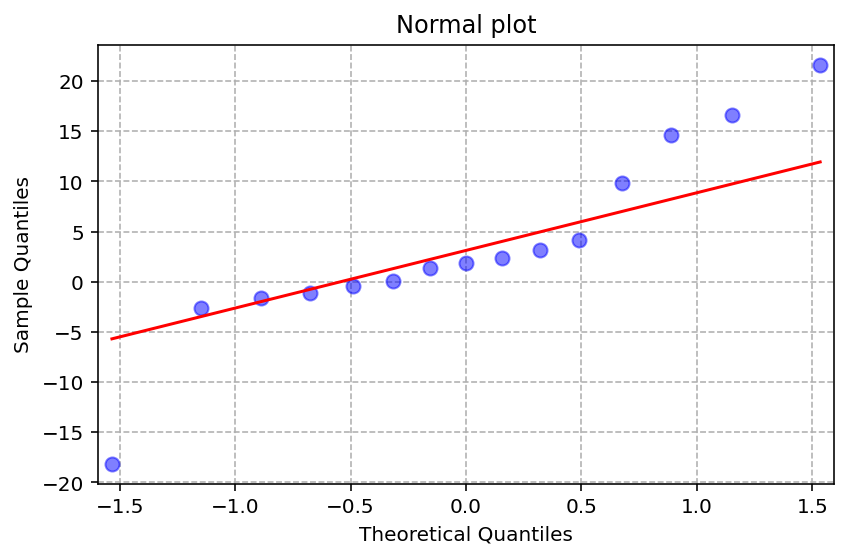

In [67]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

effects = np.array([21.625,3.125,9.875,14.625,0.125,-18.125,16.625,
                    2.375,-0.375,-1.125,1.875,4.125,-1.625,-2.625,1.375])
sm.graphics.qqplot(effects,line='q', alpha=0.5, ms=7)
plt.title('Normal plot')
plt.tight_layout()
plt.grid(ls='--')
pass;

Normal probability plot in Minitab style

In [68]:
# Input: effects = a dictionary of all effects 
#        type = normal or halfnormal
#        sig_eff = a list of significant effects

def effect_plot(effects, type='normal', sig_eff=None):
  
  n = len(effects)
  val = list(effects.values())
  Y = np.abs(val) if type=='halfnormal' else val
  Y = np.array(Y)

  # Determine sample quantiles from normal distribution and plot them against the effects.
  sample_cdf = (np.array(range(1, n+1)) - 0.5)/n  
  if type == 'halfnormal':
    sample_q = stats.halfnorm.ppf(sample_cdf) 
  else:
    sample_q = stats.norm.ppf(sample_cdf)

  _,ax = plt.subplots(figsize=(5,5))
  plt.scatter(sorted(Y), sample_q, color='blue', marker='s', s=50, alpha=0.5)

  # Set the % normal probability labels for the y-axis.
  if type=='halfnormal':
    #probs = np.array([1,10, 20, 30, 40, 50, 60,70,80,90,95,97,99])/100
    probs = np.array([1,10,20,30,40,50,60,70,80,90,95,97,99])/100
    theoretical_q = stats.halfnorm.ppf(probs)
  else:
    probs = np.array([1,5,10,20,30,40,50,60,70,80,90,95,99])/100
    theoretical_q = stats.norm.ppf(probs)
  

  plt.yticks(theoretical_q, [str(x) for x in (probs*100).astype(int)])
  plt.ylim([-0.1,2.7]) if type == 'halfnormal' else plt.ylim([-3,3])
  plt.xlim(right=1.1*max(Y))
  
  if type == 'normal':
    # Generate a line passing through quantile 0.25 and 0.75 as the reference.
    x1, x2 = np.quantile(Y, 0.25, interpolation='lower'), np.quantile(Y, 0.75, interpolation='lower')
    y1, y2 = stats.norm.ppf(0.25), stats.norm.ppf(0.75)
    
    m = (y2-y1)/(x2-x1) 
    c = y1-m*x1
    x = [sorted(Y)[0], sorted(Y)[-1]]
    y = [m*sorted(Y)[0]+c, m*sorted(Y)[-1]+c]
    
    ax.set_xlabel('Effect estimates', fontsize=14)
    ax.set_ylabel('Normal % probability', fontsize=14) 
  else:
    # Generate a line passing through the origin (0,0) and the median as the reference.
    x_median = np.quantile(Y, 0.5, interpolation='lower')
    y_median = stats.halfnorm.ppf(0.5)
    m = y_median/x_median
    x = [0, sorted(Y)[-1]]
    y = [0, m*sorted(Y)[-1]]
    
    ax.set_xlabel('|Effect estimates|')
    ax.set_ylabel('Half-normal % probability') 

  ax.tick_params(axis='y', which='major', labelsize=10) # axis='both'
  ax.tick_params(axis='y', which='minor', labelsize=8)

  
  ax.plot(x,y, color='red', alpha=0.5)
  plt.grid(ls='--')
      
  # Annotate the significant effects
  if(sig_eff):
     
    xshift = (max(Y)-min(Y))*0.02

    for i, label in enumerate(sig_eff):
      x = effects.get(label)
      if type == 'halfnormal': x = abs(x)
     
      idx = np.where(np.array(sorted(Y)) == x)[0].item()+1
      if type == 'halfnormal':
        text = ax.annotate(label, (x+xshift, stats.halfnorm.ppf((idx-0.5)/n)-0.1) )                                 
      else:
        text = ax.annotate(label, (x+xshift, stats.norm.ppf((idx-0.5)/n)-0.25) )                                 
      text.set_fontsize(12)
      
  pass;

In [69]:
effects = {'A':21.625,'B':3.125, 'C':9.875,'D':14.625,'AB':0.125, 'AC':-18.125,'AD':16.625,
          'BC':2.375, 'BD':-0.375, 'CD':-1.125, 'ABC':1.875, 'ABD':4.125,
          'ACD':-1.625,'BCD':-2.625,'ABCD':1.375}
sig_eff = ['A','C','D','AC', 'AD']

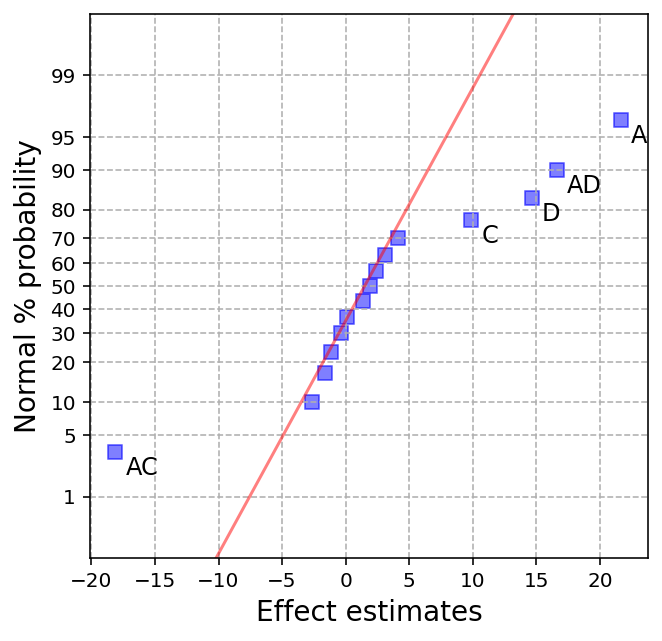

In [70]:
effect_plot(effects, type='normal', sig_eff=sig_eff)

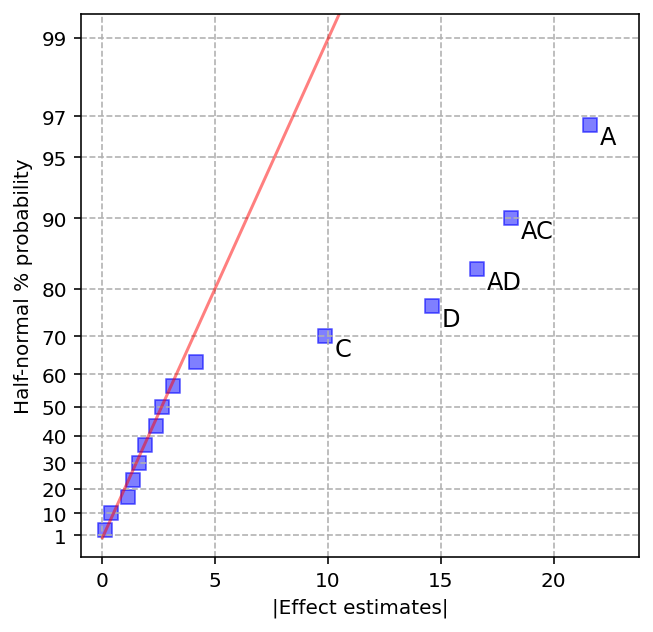

In [71]:
effect_plot(effects, type='halfnormal', sig_eff=sig_eff)

## Fractional factorial design

In [79]:
factorial_eff = gen_factorial_matrix(k=3, interaction=False, num_rep=1)

factorial_eff['E=AC'] = factorial_eff['A']*factorial_eff['C']
factorial_eff['D = BE'] = factorial_eff['B']*factorial_eff['E=AC']
factorial_eff['E = AC'] = factorial_eff['E=AC']

del factorial_eff['E=AC']

factorial_eff['AB'] = factorial_eff['A']*factorial_eff['B']
factorial_eff['AD'] = factorial_eff['A']*factorial_eff['D = BE']

factorial_eff

,I,A,B,C,D = BE,E = AC,AB,AD
0,1,-1,-1,-1,-1,1,1,1
1,1,1,-1,-1,1,-1,-1,1
2,1,-1,1,-1,1,1,-1,-1
3,1,1,1,-1,-1,-1,1,-1
4,1,-1,-1,1,1,-1,1,-1
5,1,1,-1,1,-1,1,-1,-1
6,1,-1,1,1,-1,-1,-1,1
7,1,1,1,1,1,1,1,1


In [88]:
y = np.array([[23.2], [16.9], [23.8], [16.8], [15.5], [16.2], [23.4], [18.1]])
total_y = np.c_[y]
total_y

array([[23.2],
       [16.9],
       [23.8],
       [16.8],
       [15.5],
       [16.2],
       [23.4],
       [18.1]])

In [89]:
k, n = np.log2(len(factorial_eff)), y.shape[1]

contrast_eff = factorial_eff.iloc[:,1:].mul(total_y).sum()
print('Contrast effects\n', contrast_eff.to_string(), sep='')

effects = (contrast_eff)/((2**(k-1))*n)
print('\nEffect estimates\n', effects.to_string(), sep='')

ss_eff = (contrast_eff**2)/((2**k)*n)
print('\nSS effects\n', ss_eff.to_string(), sep='')

Contrast effects
A        -17.9
B         10.3
C         -7.5
D = BE    -5.3
E = AC     8.7
AB        -6.7
AD         9.3

Effect estimates
A        -4.475
B         2.575
C        -1.875
D = BE   -1.325
E = AC    2.175
AB       -1.675
AD        2.325

SS effects
A         40.05125
B         13.26125
C          7.03125
D = BE     3.51125
E = AC     9.46125
AB         5.61125
AD        10.81125


In [83]:
alias_structure = ['[A] = A + CE', '[B] = B + DE', '[C] = C + AE', '[D] = D + BE',
                   '[E] = E + AC + BD', '[AB] = AB + CD', '[AD] = AD + BC']

effect = np.array([-1.525, -5.175, 2.275, -0.675, 2.275, 1.825, -1.275])

data = {'Alias Structure':alias_structure,'Estimates Effect':effect}

eff_estimate = pd.DataFrame(data)
eff_estimate

,Alias Structure,Estimates Effect
0,[A] = A + CE,-1.525
1,[B] = B + DE,-5.175
2,[C] = C + AE,2.275
3,[D] = D + BE,-0.675
4,[E] = E + AC + BD,2.275
5,[AB] = AB + CD,1.825
6,[AD] = AD + BC,-1.275
